In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shutil
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.regularizers import l2

IMG_WIDTH = 300
IMG_HEIGHT = 300

BATCH_SIZE = 32

DATA_PATH = ".\\dataset\\MontgomerySet"
FRAME_PATH = os.path.join(DATA_PATH, "CXR_PNG")
LEFT_MASK_PATH = os.path.join(DATA_PATH, "ManualMask\\leftMask")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def initDataForTraining():

    folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']
    
    for folder in folders:
        if(not os.path.exists(os.path.join(DATA_PATH, folder))):
            os.makedirs(os.path.join(DATA_PATH, folder))
    
    all_frames = os.listdir(FRAME_PATH)
    random.shuffle(all_frames)
    split = int(0.7*len(all_frames))

    train = all_frames[:split]
    test = all_frames[split:]
    
    for fileName in train:
        shutil.copy(os.path.join(FRAME_PATH, fileName), os.path.join(DATA_PATH, 'train_frames'))
        shutil.copy(os.path.join(LEFT_MASK_PATH, fileName), os.path.join(DATA_PATH, 'train_masks'))
    
    for fileName in test:
        shutil.copy(os.path.join(FRAME_PATH, fileName), os.path.join(DATA_PATH, 'test_frames'))
        shutil.copy(os.path.join(LEFT_MASK_PATH, fileName), os.path.join(DATA_PATH, 'test_masks'))
    
    
    
    

In [50]:
initDataForTraining()


In [8]:
trainFramePath = os.path.join(DATA_PATH, 'train_frames')
trainMaskPath = os.path.join(DATA_PATH, 'train_masks')
testFramePath = os.path.join(DATA_PATH, 'test_frames')
testMaskPath = os.path.join(DATA_PATH, 'test_masks')

In [12]:
trainFramePath

'.\\dataset\\MontgomerySet\\train_frames'

In [4]:
def loadTrainData():
    X = []
    Y = []
    files = os.listdir(trainFramePath)
    for file in files:
        imgX = img_to_array(load_img(os.path.join(trainFramePath, file)))
        imgY = img_to_array(load_img(os.path.join(trainMaskPath, file)))

        X.append(imgX/255.)
        Y.append(imgY/255.)

    return X, Y

In [21]:
def loadTrainData():
    imageNames = [f for f in os.listdir(trainFramePath)]
    X = []
    Y = []
    for index, imgName in enumerate(imageNames):
        framePath = os.path.join(trainFramePath, imgName)
        maskPath = os.path.join(trainMaskPath, imgName)
        imageX = cv2.imread(framePath, cv2.IMREAD_COLOR)
        imageX = cv2.resize(imageX, (IMG_WIDTH, IMG_HEIGHT))
        imageX = cv2.cvtColor(imageX, cv2.COLOR_BGR2RGB)
        imageY = cv2.imread(maskPath, cv2.IMREAD_COLOR)
        imageY = cv2.resize(imageY, (IMG_WIDTH, IMG_HEIGHT))
        imageY = cv2.cvtColor(imageY, cv2.COLOR_BGR2RGB)
        X.append(imageX)
        Y.append(imageY)
    return X, Y

In [ ]:
os.listdir(trainFramePath)

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_image_generator = train_datagen.flow_from_directory(
trainFramePath,
target_size=(150, 150),
class_mode=None,
batch_size = BATCH_SIZE)

train_mask_generator = train_datagen.flow_from_directory(
trainMaskPath,
target_size=(150, 150),
class_mode=None,
batch_size = BATCH_SIZE)

test_image_generator = test_datagen.flow_from_directory(
testFramePath,
target_size=(150, 150),
batch_size = BATCH_SIZE)


test_mask_generator = test_datagen.flow_from_directory(
testMaskPath,
target_size=(150, 150),
batch_size = BATCH_SIZE)

Found 138 images belonging to 1 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [10]:
train_image_generator.filepaths

[]

In [40]:
train_generator = zip(train_image_generator, train_mask_generator)

In [40]:
from tqdm import tqdm_notebook

In [46]:
im_height = 128
im_width = 128

from skimage.transform import resize

In [81]:
def get_data(framePath, maskPath, train=True):
    ids = next(os.walk(framePath))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(os.path.join(framePath, id_), grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(os.path.join(maskPath, id_), grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(trainFramePath, trainMaskPath, train=True)

Getting and resizing images ... 


c:\users\wojtek\appdata\local\conda\conda\envs\deep learning\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


In [83]:
Xt, yt = get_data(testFramePath, testMaskPath, train=True)

Getting and resizing images ... 


Done!


In [59]:
X[1].shape

(128, 128, 1)

In [58]:
cv2.imshow(X[1])

TypeError: Required argument 'mat' (pos 2) not found

In [ ]:
plt.imshow()

In [17]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [22]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [35]:
input_img = Input((128, 128, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 128, 128, 16) 64          conv2d_71[0][0]                  
__________________________________________________________________________________________________
activation_67 (Activation)      (None, 128, 128, 16) 0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
conv2d_72 

In [37]:
from keras.layers import Conv2DTranspose

from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [38]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [62]:
results = model.fit(X, y, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(Xt, yt))

Instructions for updating:
Use tf.cast instead.
Train on 96 samples, validate on 42 samples
Epoch 1/100
96/96 [==============================] - ETA: 14s - loss: 1.5332 - acc: 0.12 - ETA: 3s - loss: 1.4706 - acc: 0.1267 - 8s 88ms/step - loss: 1.4151 - acc: 0.1265 - val_loss: 2.1790 - val_acc: 0.1313

Epoch 00001: val_loss improved from inf to 2.17898, saving model to model-tgs-salt.h5
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 1.2207 - acc: 0.123 - ETA: 0s - loss: 1.1893 - acc: 0.125 - 1s 6ms/step - loss: 1.1545 - acc: 0.1319 - val_loss: 2.5531 - val_acc: 0.1646

Epoch 00002: val_loss did not improve from 2.17898
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 1.0395 - acc: 0.143 - ETA: 0s - loss: 1.0149 - acc: 0.147 - 1s 6ms/step - loss: 0.9923 - acc: 0.1532 - val_loss: 1.9481 - val_acc: 0.2319

Epoch 00003: val_loss improved from 2.17898 to 1.94812, saving model to model-tgs-salt.h5
Epoch 4/100
96/96 [==============================] - ET


Epoch 00027: val_loss did not improve from 0.52133
Epoch 28/100
96/96 [==============================] - ETA: 0s - loss: 0.4991 - acc: 0.902 - ETA: 0s - loss: 0.5013 - acc: 0.901 - 1s 6ms/step - loss: 0.4999 - acc: 0.9020 - val_loss: 0.5997 - val_acc: 0.8414

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00028: val_loss did not improve from 0.52133
Epoch 29/100
96/96 [==============================] - ETA: 0s - loss: 0.4948 - acc: 0.904 - ETA: 0s - loss: 0.5020 - acc: 0.901 - 1s 6ms/step - loss: 0.5025 - acc: 0.9013 - val_loss: 0.5941 - val_acc: 0.8478

Epoch 00029: val_loss did not improve from 0.52133
Epoch 30/100
96/96 [==============================] - ETA: 0s - loss: 0.4991 - acc: 0.903 - ETA: 0s - loss: 0.5002 - acc: 0.903 - 1s 6ms/step - loss: 0.5003 - acc: 0.9023 - val_loss: 0.5870 - val_acc: 0.8536

Epoch 00030: val_loss did not improve from 0.52133
Epoch 31/100
96/96 [==============================] - ETA: 0s - loss: 0.4968 - acc: 0.

In [ ]:
results.validation_data

In [64]:
model.load_weights('model-tgs-salt.h5')

In [65]:
model.evaluate(Xt, yt, verbose=1)

42/42 [==============================] - ETA:  - 0s 2ms/step


[0.5213318836121332, 0.834009085382734]

In [68]:
preds_train = model.predict(Xt, verbose=1)
preds_val = model.predict(yt, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

42/42 [==============================] - ETA:  - 0s 2ms/step


In [77]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='binary')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors=['black', 'white'], levels=[0.5])
    ax[0].set_title('RTG')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Left Lung')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors=['black', 'white'], levels=[0.5])
    ax[2].set_title('Predicted Lung')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Lung Binary');

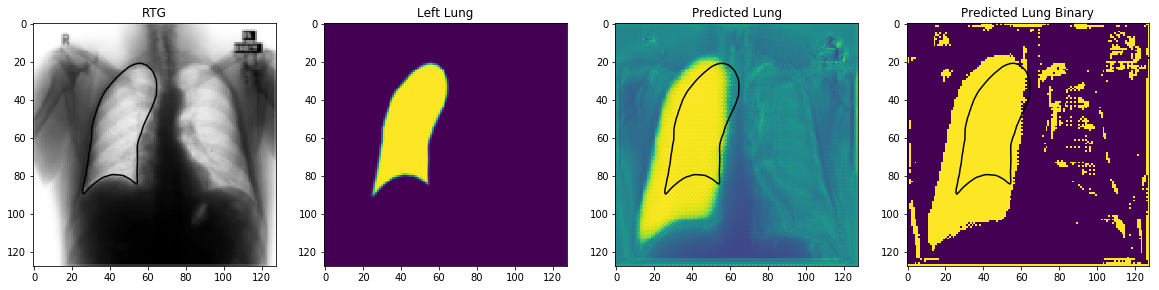

In [80]:
plot_sample(X, y, preds_train, preds_train_t, ix=22)

In [79]:
img = load_img(FRAME_PATH+"\\MCUCXR_0383_1.png")

In [74]:
x = img_to_array(img)

In [80]:
x.shape

(4020, 4892, 3)

In [78]:
x.shape

(4020, 4892, 3)

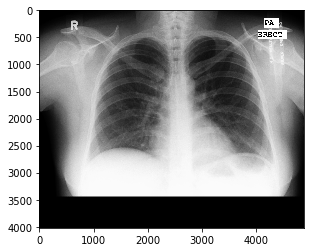

In [88]:
plt.imshow(x/255.)

In [85]:
train_datagen = ImageDataGenerator(rescale=1./255)

Found 0 images belonging to 0 classes.


In [ ]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape())